# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# Rozwiązanie

In [3]:
%matplotlib notebook

### Generatory punktów

In [4]:
def generate_points_square(amount, low, high, dtype):
    a = np.random.rand(amount).astype(dtype) * (high - low) + low
    b = np.random.rand(amount).astype(dtype) * (high - low) + low
    return list(zip(a, b))

In [5]:
def generate_points_circle(amount, radius, dtype):
    x = np.random.rand(amount).astype(dtype) * 2 * np.pi
    a = np.cos(x) * radius
    b = np.sin(x) * radius
    return list(zip(a, b))

In [6]:
def generate_points_segment(amount, a, b, low, high, dtype):
    x = np.random.rand(amount).astype(dtype) * (high - low) + low
    t = (x - a[0]) / (b[0] - a[0])
    y = a[1] + (b[1] - a[1]) * t
    return list(zip(x, y))

### Zestaw danych 1

<IPython.core.display.Javascript object>


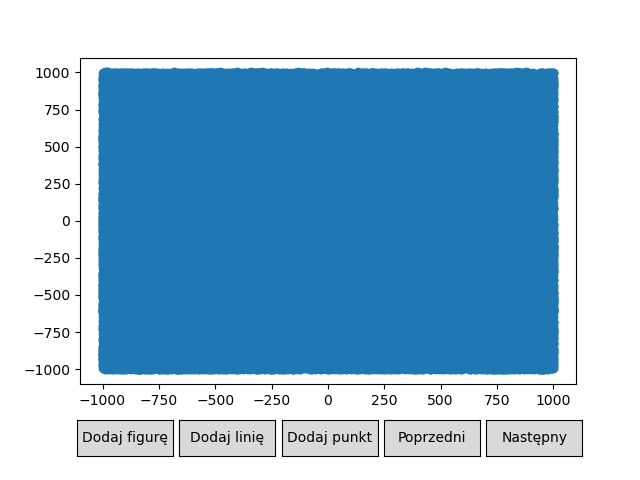

In [7]:
# 10**5 losowych punktów o współrzędnych z przedziału [-1000, 1000]
points1_float32 = generate_points_square(10 ** 5, -10 ** 3, 10 ** 3, np.float32)
points1_float64 = generate_points_square(10 ** 5, -10 ** 3, 10 ** 3, np.float64)

plot = Plot(points=[PointsCollection(points1_float64)])
plot.draw()

### Zestaw danych 2

<IPython.core.display.Javascript object>


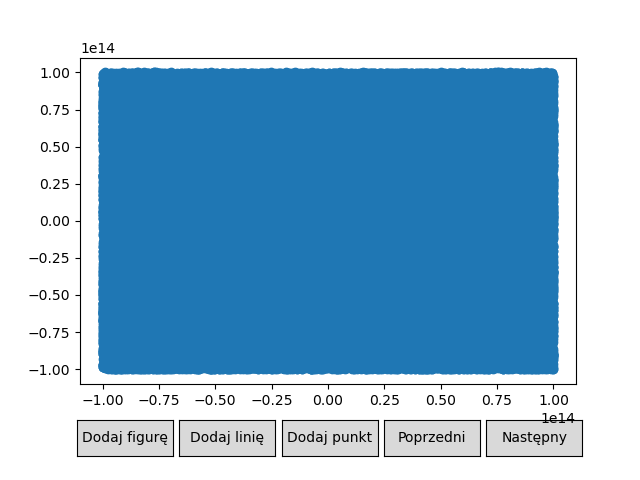

In [8]:
# 10**5 losowych punktów o współrzędnych z przedziału [-10**14,10**14]
points2_float32 = generate_points_square(10 ** 5, -10 ** 14, 10 ** 14, np.float32)
points2_float64 = generate_points_square(10 ** 5, -10 ** 14, 10 ** 14, np.float64)

plot = Plot(points=[PointsCollection(points2_float64)])
plot.draw()

### Zestaw danych 3

<IPython.core.display.Javascript object>


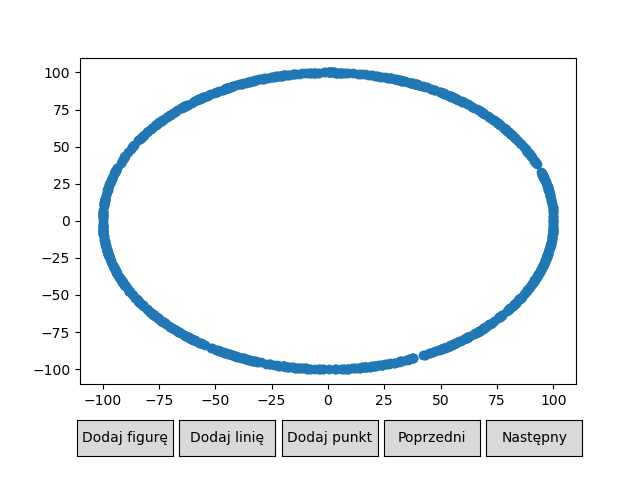

In [9]:
# 10**3 losowych punktów leżących na okręgu o środku (0,0) i promieniu R=100
# parametryzacja okręgu: x = rcos(t), y = rsin(t)

points3_float32 = generate_points_circle(10 ** 3, 100, np.float32)
points3_float64 = generate_points_circle(10 ** 3, 100, np.float64)

plot = Plot(points=[PointsCollection(points3_float64)])
plot.draw()

### Zestaw danych 4

<IPython.core.display.Javascript object>


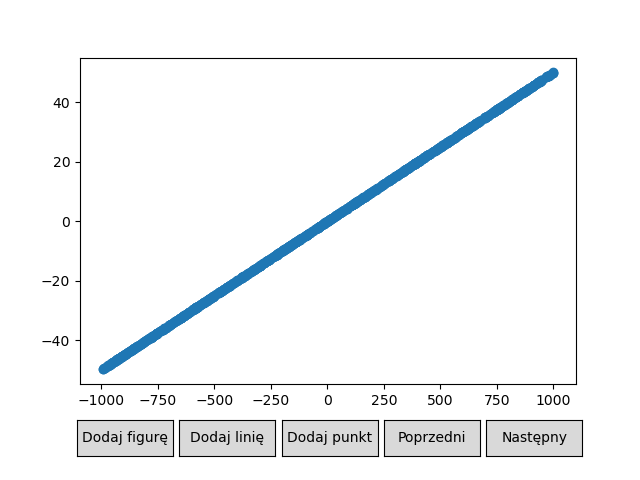

In [10]:
# 10**3 losowych punktów o współrzędnych z przedziału [-1000, 1000] leżących na prostej wyznaczonej przez wektor (a, b),
# przyjmij a = [-1.0, 0.0], b = [1.0, 0.1].
# Równanie parametryczne prostej, która przechodzi przez punkty (x1, y1) oraz (x2, y2):
# y = y1 + (y2 - y1) * t
# x = x1 + (x2 - x1) * t => t = (x - x1) / (x2 - x1) => y

a, b = [-1.0 , 0.0], [1.0, 0.1]

points4_float32 = generate_points_segment(10 ** 3, a, b, -10 ** 3, 10 ** 3, np.float32)
points4_float64 = generate_points_segment(10 ** 3, a, b, -10 ** 3, 10 ** 3, np.float64)

plot = Plot(points=[PointsCollection(points4_float64)])
plot.draw()

### Metody obliczania wyznacznika

Zaimplementowane funkcje z wykładu obliczające wyznaczniki.

In [2]:
def det_2x2(a, b, c):
    return (a[0] - c[0]) * (b[1] - c[1]) - (b[0] - c[0]) * (a[1] - c[1])


def det_3x3(a, b, c):
    return a[0] * b[1] + b[0] * c[1] + a[1] * c[0] - c[0] * b[1] - b[0] * a[1] - a[0] * c[1]

Obliczenie tych samych wyznaczników, ale korzystając z funkcji bibliotecznej np.linalg.det(). 

In [3]:
def det_2x2_library(a, b, c):
    matrix = np.array([[a[0] - c[0], a[1] - c[1]], [b[0] - c[0], b[1] - c[1]]])
    return np.linalg.det(matrix)


def det_3x3_library(a, b, c):
    matrix = np.array([[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]])
    return np.linalg.det(matrix)

### Klasyfikacja

In [13]:
tolerances = [10e-16, 10e-14, 10e-12,10e-10] # przyjęte tolerancje

Funkcja przydzielająca punkty do odpowiednich tablic, w zależności po której stronie dany punkt się znajduje.

In [14]:
def find_group(points, determinant_func, tolerance=0):
    left, right, collinear = [], [], []
    a, b = [-1.0, 0.0], [1.0, 0.1]
    
    for point in points:
        det = determinant_func(a, b, point)
        
        if det < -tolerance:
            right.append(point)
        elif det > tolerance:
            left.append(point)
        else:
            collinear.append(point)
    
    return left, right, collinear

In [15]:
def print_result(points, determinant_func, tolerance=0):
    left, right, collinear = find_group(points, determinant_func, tolerance)

    plot = Plot(points=[PointsCollection(left, color='palevioletred'),
                        PointsCollection(right, color='pink'),
                        PointsCollection(collinear, color='lime')])
    
    plot.draw()
    print("Number of points:")
    print(f"Left side: {len(left)}")
    print(f"Right side: {len(right)}")
    print(f"Collinear: {len(collinear)}")

## Porównywanie wyników otrzymanych korzystając z procedur bibliotecznych oraz zaimplementowanych dla float64.

#### Zestaw danych 1

<IPython.core.display.Javascript object>


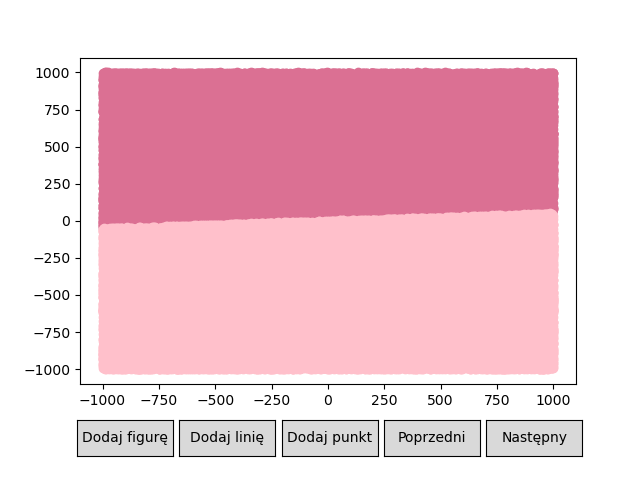

Number of points:
Left side: 49968
Right side: 50032
Collinear: 0


In [16]:
print_result(points1_float64, det_2x2)

<IPython.core.display.Javascript object>


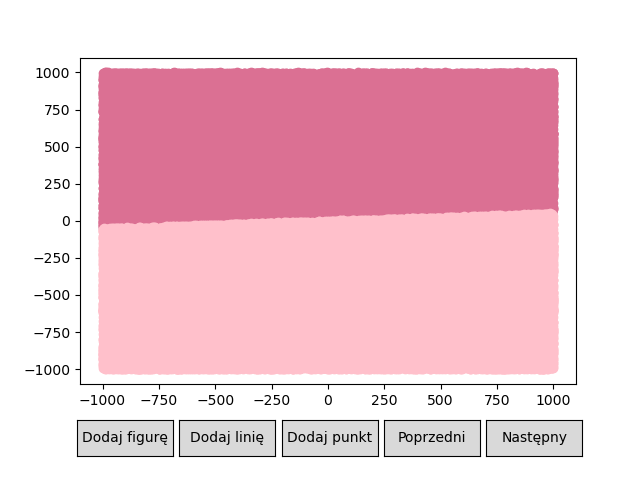

Number of points:
Left side: 49968
Right side: 50032
Collinear: 0


In [17]:
print_result(points1_float64, det_3x3)

<IPython.core.display.Javascript object>


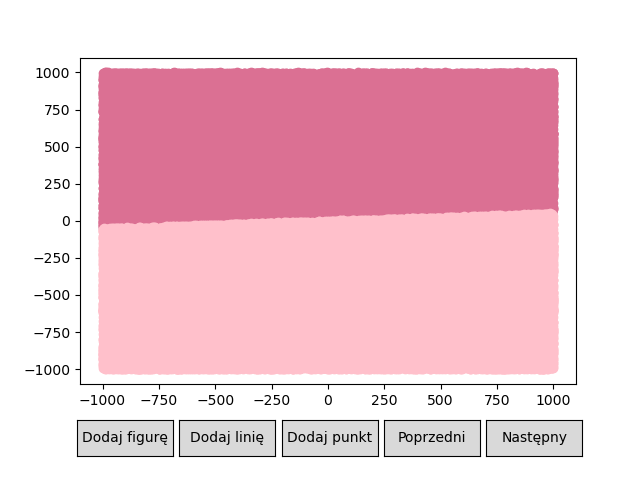

Number of points:
Left side: 49968
Right side: 50032
Collinear: 0


In [18]:
print_result(points1_float64, det_2x2_library)

<IPython.core.display.Javascript object>


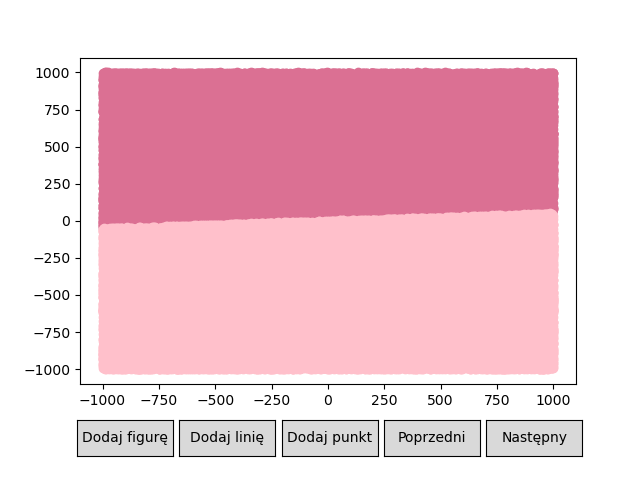

Number of points:
Left side: 49968
Right side: 50032
Collinear: 0


In [19]:
print_result(points1_float64, det_3x3_library)

#### Zestaw danych 2

<IPython.core.display.Javascript object>


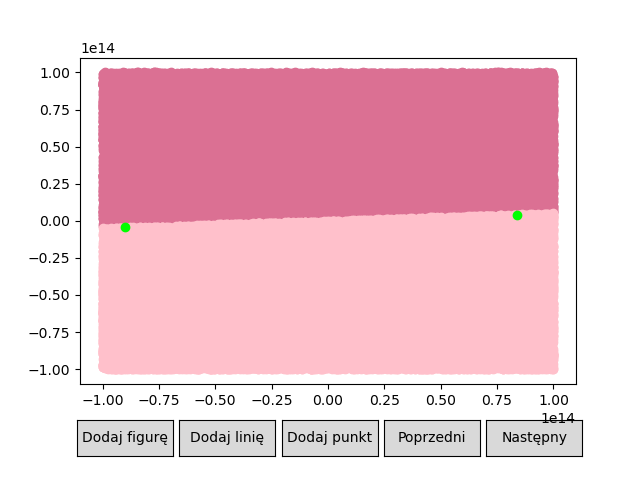

Number of points:
Left side: 50027
Right side: 49971
Collinear: 2


In [20]:
print_result(points2_float64, det_2x2)

<IPython.core.display.Javascript object>


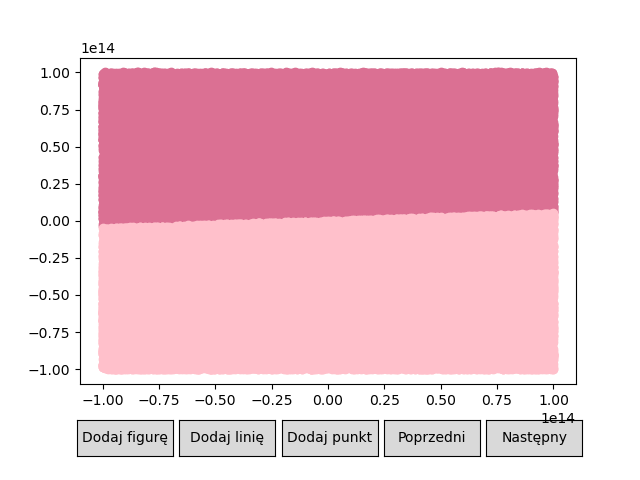

Number of points:
Left side: 50028
Right side: 49972
Collinear: 0


In [21]:
print_result(points2_float64, det_3x3)

<IPython.core.display.Javascript object>


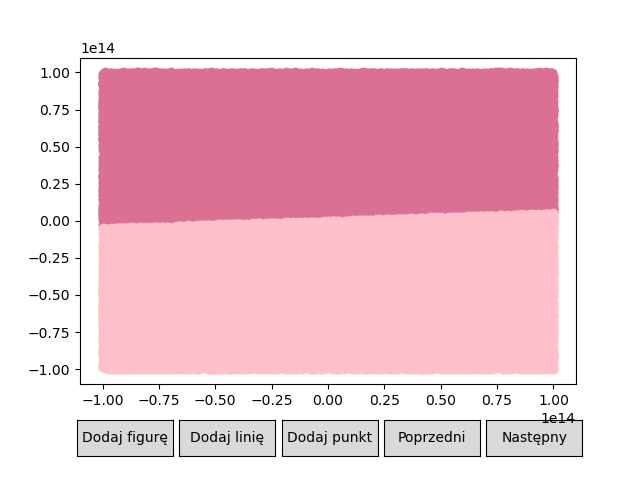

Number of points:
Left side: 50027
Right side: 49973
Collinear: 0


In [22]:
print_result(points2_float64, det_2x2_library)

<IPython.core.display.Javascript object>


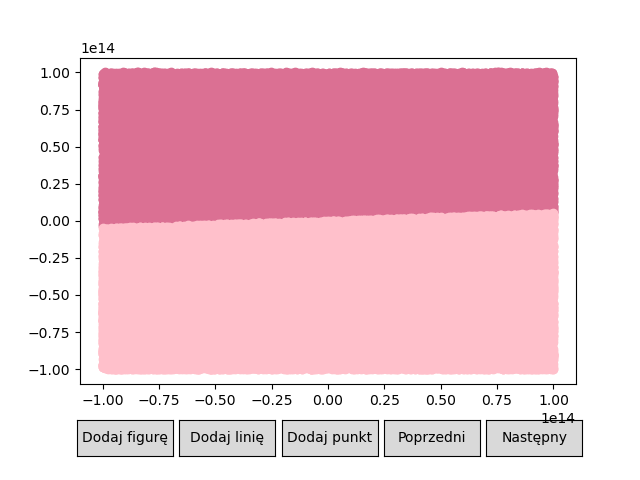

Number of points:
Left side: 50028
Right side: 49972
Collinear: 0


In [23]:
print_result(points2_float64, det_3x3_library)

#### Zestaw danych 3

<IPython.core.display.Javascript object>


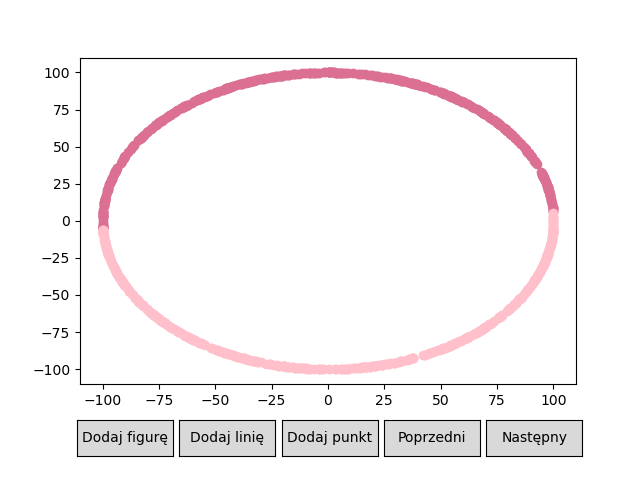

Number of points:
Left side: 475
Right side: 525
Collinear: 0


In [24]:
print_result(points3_float64, det_2x2)

<IPython.core.display.Javascript object>


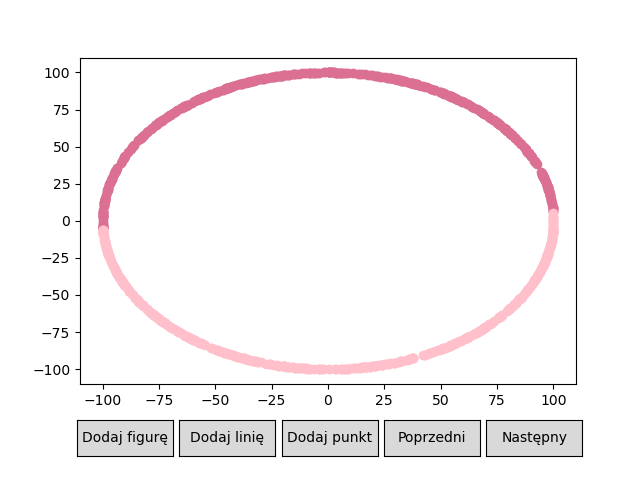

Number of points:
Left side: 475
Right side: 525
Collinear: 0


In [25]:
print_result(points3_float64, det_3x3)

<IPython.core.display.Javascript object>


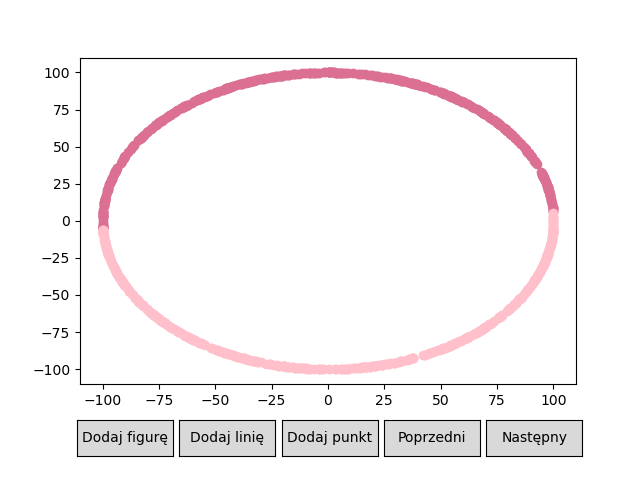

Number of points:
Left side: 475
Right side: 525
Collinear: 0


In [26]:
print_result(points3_float64, det_2x2_library)

<IPython.core.display.Javascript object>


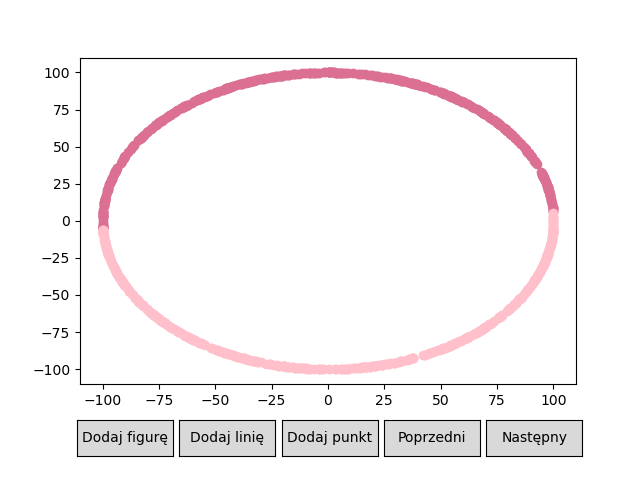

Number of points:
Left side: 475
Right side: 525
Collinear: 0


In [27]:
print_result(points3_float64, det_3x3_library)

#### Zestaw danych 4

<IPython.core.display.Javascript object>


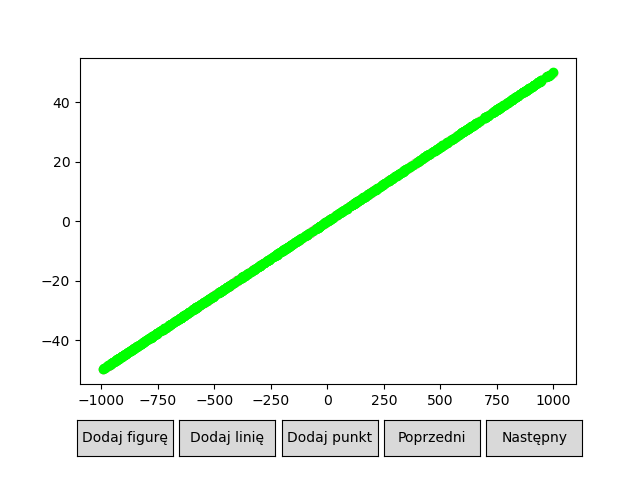

Number of points:
Left side: 128
Right side: 159
Collinear: 713


In [28]:
print_result(points4_float64, det_2x2)

<IPython.core.display.Javascript object>


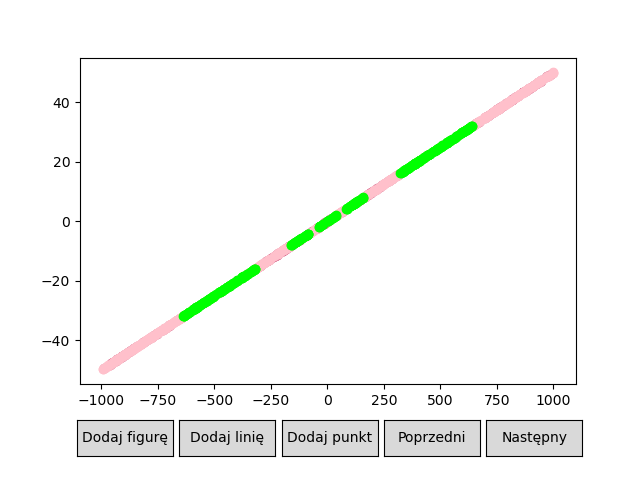

Number of points:
Left side: 243
Right side: 390
Collinear: 367


In [29]:
print_result(points4_float64, det_3x3)

<IPython.core.display.Javascript object>


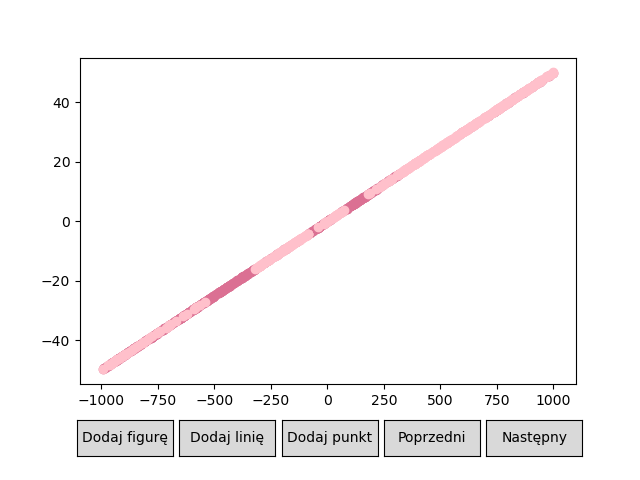

Number of points:
Left side: 486
Right side: 514
Collinear: 0


In [30]:
print_result(points4_float64, det_2x2_library)

<IPython.core.display.Javascript object>


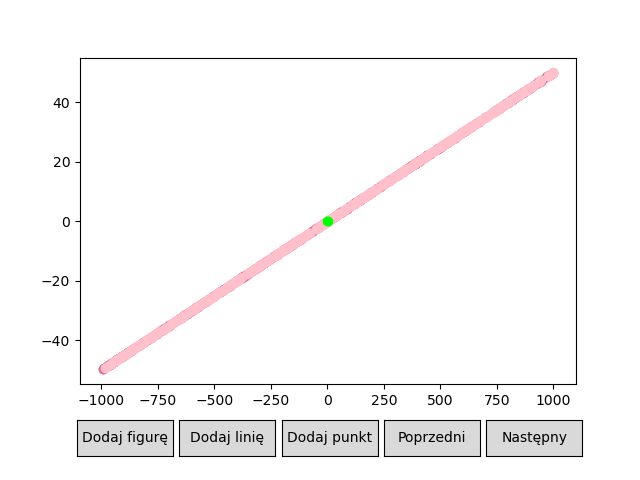

Number of points:
Left side: 487
Right side: 511
Collinear: 2


In [31]:
print_result(points4_float64, det_3x3_library)

Funkcja sprawdzająca ile punktów (i jakich) zostało inaczej zakwalifikowanych dla różnych sposobów liczenia wyznacznika.

In [32]:
def assign_groups(points, det_func, tolerance):
    left, right, collinear = find_group(points, det_func, tolerance)
    result = [[point, "LEFT"] for point in left] + \
             [[point, "RIGHT"] for point in right] + \
             [[point, "COLLINEAR"] for point in collinear]

    return result

In [33]:
def find_difference(points, det_func1, det_func2, tolerance=0):

    set1 = sorted(assign_groups(points, det_func1, tolerance))
    set2 = sorted(assign_groups(points, det_func2, tolerance))

    differences = []
    for i in range(len(points)):
        if set1[i][0] == set2[i][0] and set1[i][1] != set2[i][1]:
            differences.append(set1[i][0])

    return differences

In [2]:
def print_differences(points, det_func1, det_func2, tolerance=0):
    differences = find_difference(points, det_func1, det_func2, tolerance)
    
    print(f"Differences: {len(differences)}")
    plot = Plot(points=[PointsCollection(differences, color="pink")])
    plot.draw() if len(differences) else _

#### Zestaw danych 1:

In [35]:
print_differences(points1_float64, det_2x2, det_3x3)

Differences: 0


In [36]:
print_differences(points1_float64, det_3x3, det_3x3_library)

Differences: 0


#### Zestaw danych 2:

Differences: 3


<IPython.core.display.Javascript object>


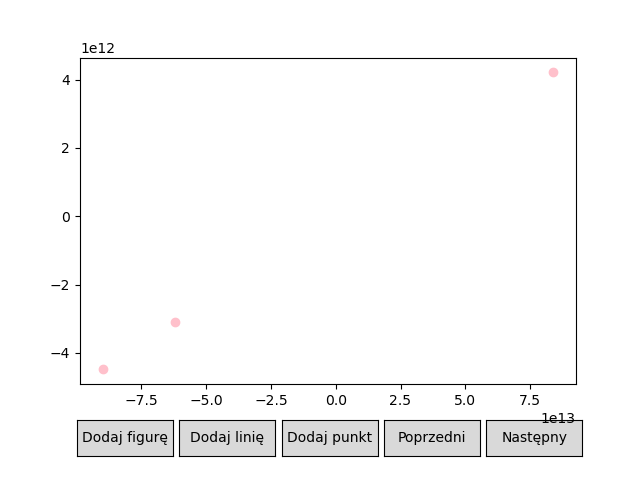

In [37]:
print_differences(points2_float64, det_2x2, det_2x2_library)

In [38]:
print_differences(points2_float64, det_3x3, det_3x3_library)

Differences: 0


#### Zestaw danych 3:

In [39]:
print_differences(points3_float64, det_2x2, det_2x2_library)

Differences: 0


In [40]:
print_differences(points3_float64, det_3x3, det_3x3_library)

Differences: 0


#### Zestaw danych 4:

Differences: 732


<IPython.core.display.Javascript object>


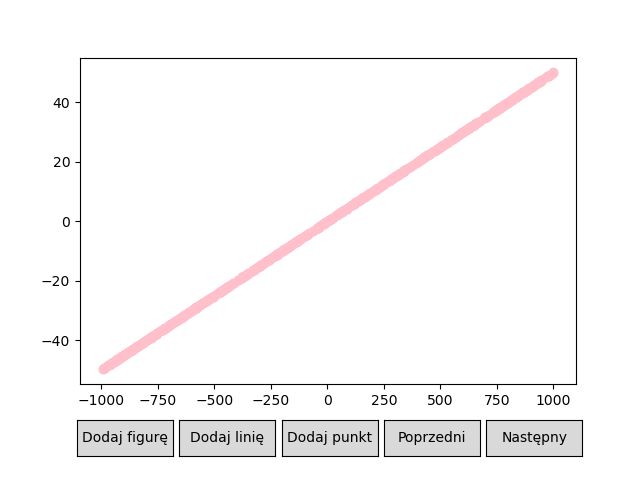

In [41]:
print_differences(points4_float64, det_2x2, det_2x2_library)

Differences: 575


<IPython.core.display.Javascript object>


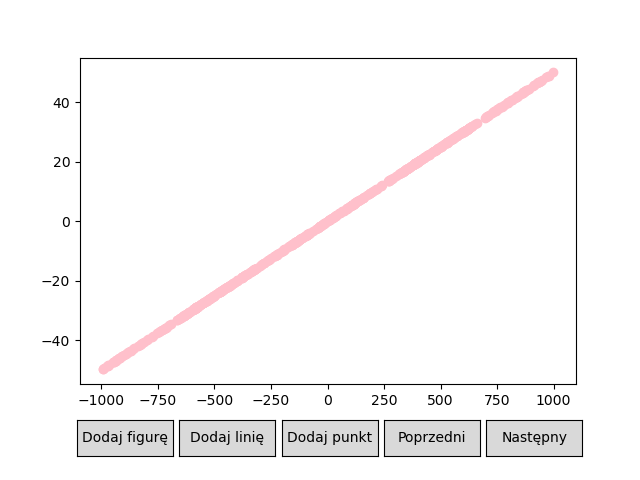

In [42]:
print_differences(points4_float64, det_3x3, det_3x3_library)

##  Badanie wyników dla różnej tolerancji dla zera oraz różnych precyzji obliczeń.

In [43]:
def summary(points):
    determinants = [det_2x2, det_3x3, det_2x2_library, det_3x3_library]
    descriptions = ["2x2 zaimplementowany", "3x3 zaimplementowany", "2x2 biblioteczny", "3x3 biblioteczny"]
    scenes = []
    
    for i in range(4):
        print(f"\nWyznacznik: {descriptions[i]}:")
        for tolerance in tolerances:
            left, right, collinear = find_group(points, determinants[i], tolerance)
            print(f"\t Tolerance: {tolerance} |\t Left: {len(left)}\t Right: {len(right)}\t Collinear: {len(collinear)}")
            scenes.append(Scene([PointsCollection(left, color='hotpink'), PointsCollection(right, color='pink'),PointsCollection(collinear, color='lime')]))
    return scenes

### Dla precyzji float64


Wyznacznik: 2x2 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 49968	 Right: 50032	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 49968	 Right: 50032	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 49968	 Right: 50032	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 49968	 Right: 50032	 Collinear: 0

Wyznacznik: 3x3 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 49968	 Right: 50032	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 49968	 Right: 50032	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 49968	 Right: 50032	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 49968	 Right: 50032	 Collinear: 0

Wyznacznik: 2x2 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 49968	 Right: 50032	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 49968	 Right: 50032	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 49968	 Right: 50032	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 49968	 Right: 50032	 Collinear: 0

Wyznacznik: 3x3 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 49968	 Right: 50032	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 49968	 Right: 50032	 Collinear: 0


<IPython.core.display.Javascript object>


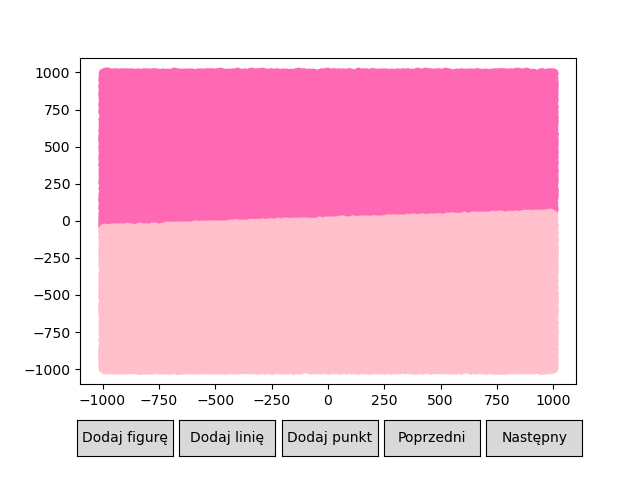

In [44]:
scenes = summary(points1_float64)
plot = Plot(scenes=scenes)
plot.draw()


Wyznacznik: 2x2 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 50027	 Right: 49971	 Collinear: 2
	 Tolerance: 1e-13 |	 Left: 50027	 Right: 49971	 Collinear: 2
	 Tolerance: 1e-11 |	 Left: 50027	 Right: 49971	 Collinear: 2
	 Tolerance: 1e-09 |	 Left: 50027	 Right: 49971	 Collinear: 2

Wyznacznik: 3x3 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 50028	 Right: 49972	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 50028	 Right: 49972	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 50028	 Right: 49972	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 50028	 Right: 49972	 Collinear: 0

Wyznacznik: 2x2 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 50027	 Right: 49973	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 50027	 Right: 49973	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 50027	 Right: 49973	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 50027	 Right: 49973	 Collinear: 0

Wyznacznik: 3x3 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 50028	 Right: 49972	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 50028	 Right: 49972	 Collinear: 0


<IPython.core.display.Javascript object>


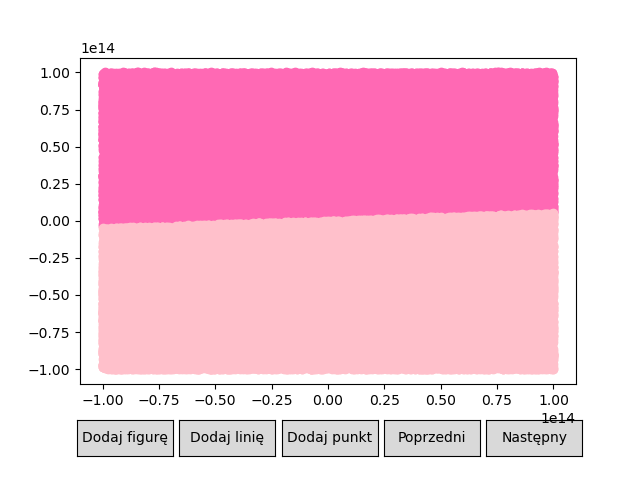

In [52]:
scenes = summary(points2_float64)
plot = Plot(scenes=scenes)
plot.draw()


Wyznacznik: 2x2 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 475	 Right: 525	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 475	 Right: 525	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 475	 Right: 525	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 475	 Right: 525	 Collinear: 0

Wyznacznik: 3x3 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 475	 Right: 525	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 475	 Right: 525	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 475	 Right: 525	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 475	 Right: 525	 Collinear: 0

Wyznacznik: 2x2 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 475	 Right: 525	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 475	 Right: 525	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 475	 Right: 525	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 475	 Right: 525	 Collinear: 0

Wyznacznik: 3x3 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 475	 Right: 525	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 475	 Right: 525	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 475	 Right: 525	 Collinear: 

<IPython.core.display.Javascript object>


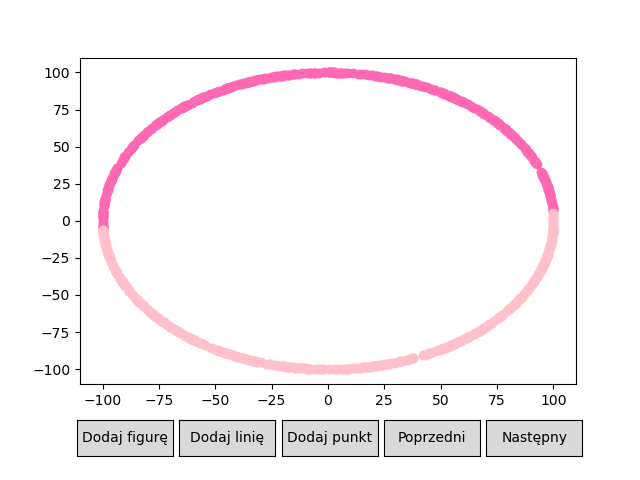

In [46]:
scenes = summary(points3_float64)
plot = Plot(scenes=scenes)
plot.draw()


Wyznacznik: 2x2 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 123	 Right: 157	 Collinear: 720
	 Tolerance: 1e-13 |	 Left: 114	 Right: 137	 Collinear: 749
	 Tolerance: 1e-11 |	 Left: 0	 Right: 0	 Collinear: 1000
	 Tolerance: 1e-09 |	 Left: 0	 Right: 0	 Collinear: 1000

Wyznacznik: 3x3 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 219	 Right: 364	 Collinear: 417
	 Tolerance: 1e-13 |	 Left: 0	 Right: 0	 Collinear: 1000
	 Tolerance: 1e-11 |	 Left: 0	 Right: 0	 Collinear: 1000
	 Tolerance: 1e-09 |	 Left: 0	 Right: 0	 Collinear: 1000

Wyznacznik: 2x2 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 459	 Right: 502	 Collinear: 39
	 Tolerance: 1e-13 |	 Left: 340	 Right: 382	 Collinear: 278
	 Tolerance: 1e-11 |	 Left: 0	 Right: 0	 Collinear: 1000
	 Tolerance: 1e-09 |	 Left: 0	 Right: 0	 Collinear: 1000

Wyznacznik: 3x3 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 340	 Right: 346	 Collinear: 314
	 Tolerance: 1e-13 |	 Left: 0	 Right: 0	 Collinear: 1000
	 Tolerance: 1e-11 |	 Left: 0	 Right: 0	 Collinear: 1

<IPython.core.display.Javascript object>


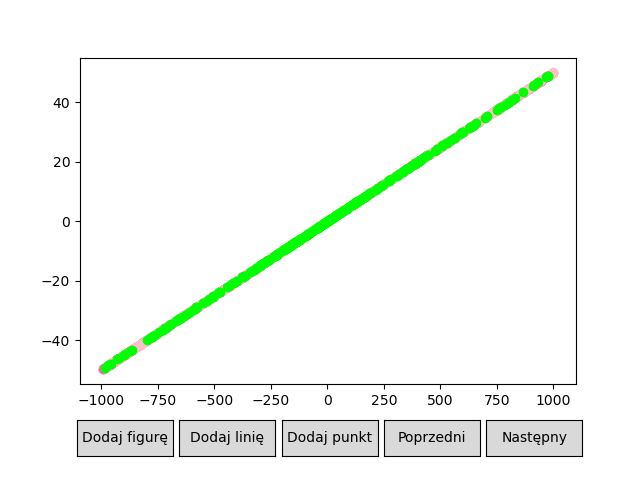

In [54]:
scenes = summary(points4_float64)
plot = Plot(scenes=scenes)
plot.draw()

### Dla precyzji float32


Wyznacznik: 2x2 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 50056	 Right: 49944	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 50056	 Right: 49944	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 50056	 Right: 49944	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 50056	 Right: 49944	 Collinear: 0

Wyznacznik: 3x3 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 50056	 Right: 49944	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 50056	 Right: 49944	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 50056	 Right: 49944	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 50056	 Right: 49944	 Collinear: 0

Wyznacznik: 2x2 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 50056	 Right: 49944	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 50056	 Right: 49944	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 50056	 Right: 49944	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 50056	 Right: 49944	 Collinear: 0

Wyznacznik: 3x3 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 50056	 Right: 49944	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 50056	 Right: 49944	 Collinear: 0


<IPython.core.display.Javascript object>


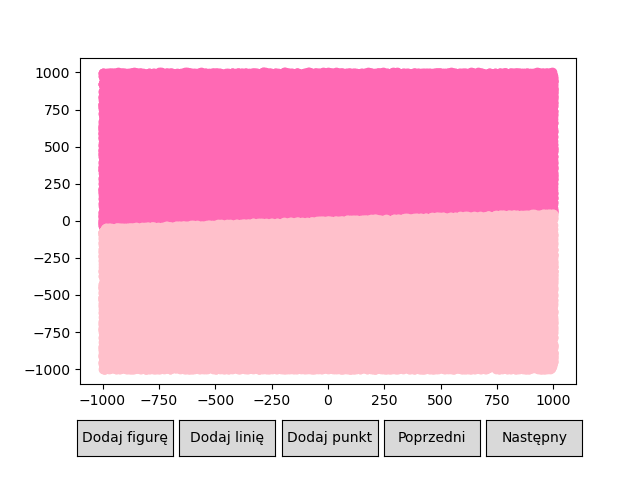

In [48]:
scenes = summary(points1_float32)
plot = Plot(scenes=scenes)
plot.draw()


Wyznacznik: 2x2 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 50032	 Right: 49960	 Collinear: 8
	 Tolerance: 1e-13 |	 Left: 50032	 Right: 49960	 Collinear: 8
	 Tolerance: 1e-11 |	 Left: 50032	 Right: 49960	 Collinear: 8
	 Tolerance: 1e-09 |	 Left: 50032	 Right: 49960	 Collinear: 8

Wyznacznik: 3x3 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 50035	 Right: 49965	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 50035	 Right: 49965	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 50035	 Right: 49965	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 50035	 Right: 49965	 Collinear: 0

Wyznacznik: 2x2 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 50037	 Right: 49963	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 50037	 Right: 49963	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 50037	 Right: 49963	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 50037	 Right: 49963	 Collinear: 0

Wyznacznik: 3x3 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 50035	 Right: 49965	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 50035	 Right: 49965	 Collinear: 0


<IPython.core.display.Javascript object>


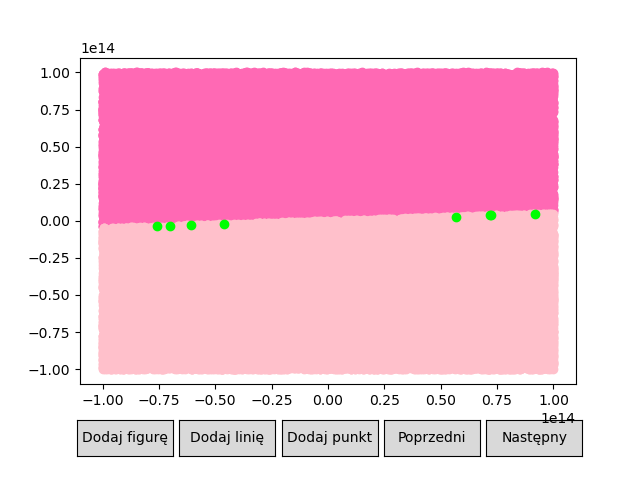

In [55]:
scenes = summary(points2_float32)
plot = Plot(scenes=scenes)
plot.draw()


Wyznacznik: 2x2 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 500	 Right: 500	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 500	 Right: 500	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 500	 Right: 500	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 500	 Right: 500	 Collinear: 0

Wyznacznik: 3x3 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 500	 Right: 500	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 500	 Right: 500	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 500	 Right: 500	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 500	 Right: 500	 Collinear: 0

Wyznacznik: 2x2 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 500	 Right: 500	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 500	 Right: 500	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 500	 Right: 500	 Collinear: 0
	 Tolerance: 1e-09 |	 Left: 500	 Right: 500	 Collinear: 0

Wyznacznik: 3x3 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 500	 Right: 500	 Collinear: 0
	 Tolerance: 1e-13 |	 Left: 500	 Right: 500	 Collinear: 0
	 Tolerance: 1e-11 |	 Left: 500	 Right: 500	 Collinear: 

<IPython.core.display.Javascript object>


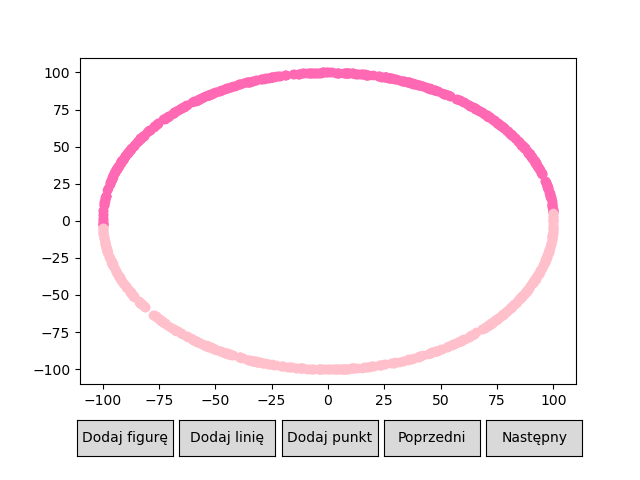

In [50]:
scenes = summary(points3_float32)
plot = Plot(scenes=scenes)
plot.draw()


Wyznacznik: 2x2 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 400	 Right: 400	 Collinear: 200
	 Tolerance: 1e-13 |	 Left: 396	 Right: 400	 Collinear: 204
	 Tolerance: 1e-11 |	 Left: 389	 Right: 393	 Collinear: 218
	 Tolerance: 1e-09 |	 Left: 389	 Right: 393	 Collinear: 218

Wyznacznik: 3x3 zaimplementowany:
	 Tolerance: 1e-15 |	 Left: 460	 Right: 467	 Collinear: 73
	 Tolerance: 1e-13 |	 Left: 389	 Right: 393	 Collinear: 218
	 Tolerance: 1e-11 |	 Left: 389	 Right: 393	 Collinear: 218
	 Tolerance: 1e-09 |	 Left: 389	 Right: 393	 Collinear: 218

Wyznacznik: 2x2 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 499	 Right: 495	 Collinear: 6
	 Tolerance: 1e-13 |	 Left: 465	 Right: 469	 Collinear: 66
	 Tolerance: 1e-11 |	 Left: 389	 Right: 393	 Collinear: 218
	 Tolerance: 1e-09 |	 Left: 389	 Right: 393	 Collinear: 218

Wyznacznik: 3x3 biblioteczny:
	 Tolerance: 1e-15 |	 Left: 473	 Right: 463	 Collinear: 64
	 Tolerance: 1e-13 |	 Left: 389	 Right: 393	 Collinear: 218
	 Tolerance: 1e-11 |	 Left: 389	 

<IPython.core.display.Javascript object>


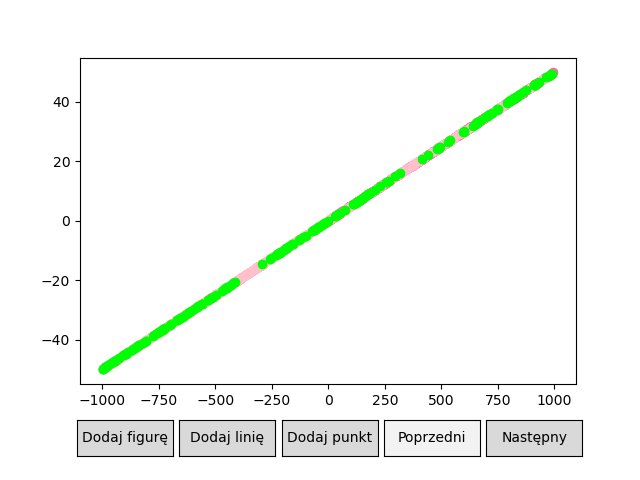

In [51]:
scenes = summary(points4_float32)
plot = Plot(scenes=scenes)
plot.draw()

# Porównanie czasu działania funkcji obliczania wyznacznika

In [13]:
from datetime import datetime

def calculate_time(method, T):
    start = datetime.now()
    
    for a, b, c in T:
        ans = method[0](a,b,c)
        
    stop = datetime.now()
    diff = stop - start
    diff = str(diff)
    print("Czas obliczeń dla funkcji " + method[1] + " to: " + diff[-9:] + " sekundy.")
    

In [12]:
methods = [[det_2x2_library, "2x2 z biblioteki numpy"], \
           [det_3x3_library, "3x3 z biblioteki numpy"], \
           [det_2x2, "2x2 własnej implementacji"], \
           [det_3x3, "3x3 własnej implementacji"]]

In [14]:
test= []

for _ in range(10**6):
    test.append([[random.uniform(0,1000),random.uniform(0,1000)], \
                [random.uniform(0,1000),random.uniform(0,1000)], \
                [random.uniform(0,1000),random.uniform(0,1000)]])
    
calculate_time(methods[0], test)
calculate_time(methods[1], test)
calculate_time(methods[2], test)
calculate_time(methods[3], test)

Czas obliczeń dla funkcji 2x2 z biblioteki numpy to: 07.066931 sekundy.
Czas obliczeń dla funkcji 3x3 z biblioteki numpy to: 07.775131 sekundy.
Czas obliczeń dla funkcji 2x2 własnej implementacji to: 00.388798 sekundy.
Czas obliczeń dla funkcji 3x3 własnej implementacji to: 00.508374 sekundy.
